# DFL + Koopman applied to extended ROA analysis

In [1]:
from darli.models import RobotModel     # Rofl, bez nee casadi ne importiruetsya
import casadi as cs
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp
from utils import draw_elipse, phase_portrait, sampling_roa

## Inverted time Van der Pol oscillator

The equation is:
$$\ddot{x} = -(1-x^2)\dot{v} - x + u$$

For the DFL linearization, let's choose:
$$\eta = \begin{bmatrix} x^2 \dot{x} \end{bmatrix}.$$


If we introduce $q = \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$
Then, the equation would be:
$$\dot{q} = \begin{bmatrix} 0 & 1 \\ -1 & -1 \end{bmatrix} q + \begin{bmatrix} 0 \\ 1 \end{bmatrix} \eta + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u \equiv A_q q + A_\eta \eta + Bu$$


In [2]:
nx, nv = 1, 1

x = cs.SX.sym('x', nx)
v = cs.SX.sym('v', nv)
dv = cs.SX.sym('dv', nv)

state = cs.vertcat(x, v)
state_dot = cs.vertcat(v, dv)

In [3]:
neta_dfl = 1
neta_rbf = 20

# Inverted-time Van der Pol no. 1
# f = cs.Function("f", [state], [cs.vertcat(v, -(1-x**2)*v - x)])
# eta = x**2 * v
# A_x = np.array([[0, 1], [-1, -1]])
# A_eta = np.array([0, 1]).reshape(-1, 1)

# Inverted-time Van der Pol no. 2
f = cs.Function("f", [state], [cs.vertcat(v, -x-v + (x**3)/3)])
eta = x**3 / 3
A_x = np.array([[0, 1], [-1, -1]])
A_eta = np.array([0, 1]).reshape(-1, 1)

# Pendulum
# f = cs.Function("f", [state], [cs.vertcat(v, -9.81 * cs.sin(x))])
# eta = -cs.sin(x)
# A_x = np.array([[0, 1], [0, 0]])
# A_eta = np.array([0, 9.81]).reshape(-1, 1)

x0_range = (-1, 1)
x0 = cs.SX.sym('x0', nx+nv)
rbf = cs.Function('psi', [state, x0], [cs.norm_2(state - x0)**2 * cs.log(cs.norm_2(state - x0))])
random_rbfs = [
    rbf(state, np.random.uniform(*x0_range, size=(nx+nv))) 
    for _ in range(neta_rbf)
]
eta = cs.vertcat(eta, *random_rbfs)
neta = neta_dfl + neta_rbf

In [4]:
# There would be two types of symbolic etas: eta(x) and eta as free variable
# It's important to note which variable is used
eta_sym = cs.SX.sym('eta', neta)

In [5]:
eta_fn = cs.Function("eta", [state], [eta])

# State + auxiliary variables
full_state = cs.vertcat(state, eta)
full_state_sym = cs.vertcat(state, eta_sym)

In [6]:
# Verification that matrices are chosed correctly
f_lin = cs.Function("f_lin", [state], [A_x @ state + A_eta @ eta[:neta_dfl]])

state_np = np.random.uniform(-2, 2, size=(2,))

f_lin(state_np), f(state_np)

(DM([-0.999487, 0.383876]), DM([-0.999487, 0.383876]))

### Data sampling

In [7]:
# Simulation parameters
dt_sim = 1e-3
dt_sample = 1e-1
n_samples = 100
t_end = 10
x_range = (-5, 5)

In [8]:
ts = np.arange(0, t_end, dt_sim)
save_each = int(dt_sample / dt_sim)
state_samples = []

f_np = lambda t, x: np.array(f(x)).ravel()

progress_bar = tqdm(total=n_samples)

while len(state_samples) < n_samples:
    state_np = np.random.uniform(*x_range, size=(2,))
    sol = solve_ivp(
        f_np,
        (0, t_end),
        state_np,
        t_eval=ts
    )
    if sol.status == 0:
        progress_bar.update(1)
        state_samples.append(sol.y.T[::save_each])
progress_bar.close()

  1%|          | 1/100 [00:00<00:34,  2.84it/s]

100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


In [9]:
state_np = np.concatenate(state_samples, axis=0)
v_dot_np = np.array([
    f_np(0, state_i) for state_i in state_np
])

state_np.shape

(10000, 2)

In [10]:
eta_dot = cs.jacobian(eta, state) @ state_dot
eta_dot_fn = cs.Function(
    "eta_dot", 
    [state, dv], 
    [
        eta_dot
    ]
)

eta_np = np.array([
    eta_fn(state_i) for state_i in state_np
])[:, :, 0]

In [11]:
eta_dot_np = np.array([
    eta_dot_fn(state_i, v_dot_i[1]) for state_i, v_dot_i in zip(state_np, v_dot_np)
])[:, :, 0]

In [12]:
full_state_np = np.concatenate([state_np, eta_np], axis=1)

full_state_np.shape

(10000, 23)

In [13]:
full_state_dot_np = np.concatenate([v_dot_np, eta_dot_np], axis=1)

full_state_dot_np.shape

(10000, 23)

In [14]:
full_state_np.max()

84.29253858748277

In [15]:
# Option 1: fitting only auxiliary variable's dynamics
# H_w_cp = cp.Variable((neta, nx+nv+neta))
# objective_samples = 1/len(full_state_np) * cp.sum_squares(eta_dot_np.T - H_w_cp@full_state_np.T) #+ 0.1*cp.norm(H_w_cp)

# Option 2: fitting whole dynamics
H_w_cp = cp.Variable((nx+nv+neta, nx+nv+neta))
objective_samples = cp.sum_squares(full_state_dot_np.T - H_w_cp@full_state_np.T) #+ 0.1*cp.norm(H_w_cp)

problem_samples = cp.Problem(cp.Minimize(objective_samples))
result = problem_samples.solve(verbose=True)


H_w = H_w_cp.value

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 11 02:17:09 PM: Your problem has 529 variables, 0 constraints, and 0 parameters.
(CVXPY) Jan 11 02:17:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 11 02:17:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 11 02:17:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 11 02:17:09 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 11 02:17:09 PM: Compiling problem (target solver=OSQP).
(CV

In [16]:
t_end = 10
ts = np.arange(0, t_end, dt_sim)
# def f_lin(t, x):
#     state, eta = x[:nx+nv], x[nx+nv:]
#     state_dot = A_x @ state + A_eta @ eta[:neta_dfl]
#     eta_dot = H_w @ x

#     return np.concatenate([state_dot, eta_dot])

def f_lin(t, x):
    return H_w @ x

# state_np = np.random.uniform(-2, 2, size=(2, ))
state_np = np.array([-1, 2])
eta_np = np.array(eta_fn(state_np)).ravel()

full_state_np = np.concatenate([state_np, eta_np], axis=0)

sol = solve_ivp(
    f_np,
    (0, t_end),
    state_np,
    t_eval=ts
)

lin_sol = solve_ivp(
    f_lin,
    (0, t_end),
    full_state_np,
    t_eval=ts
)

In [17]:
sol.y.shape, lin_sol.y.shape

((2, 10000), (23, 10000))

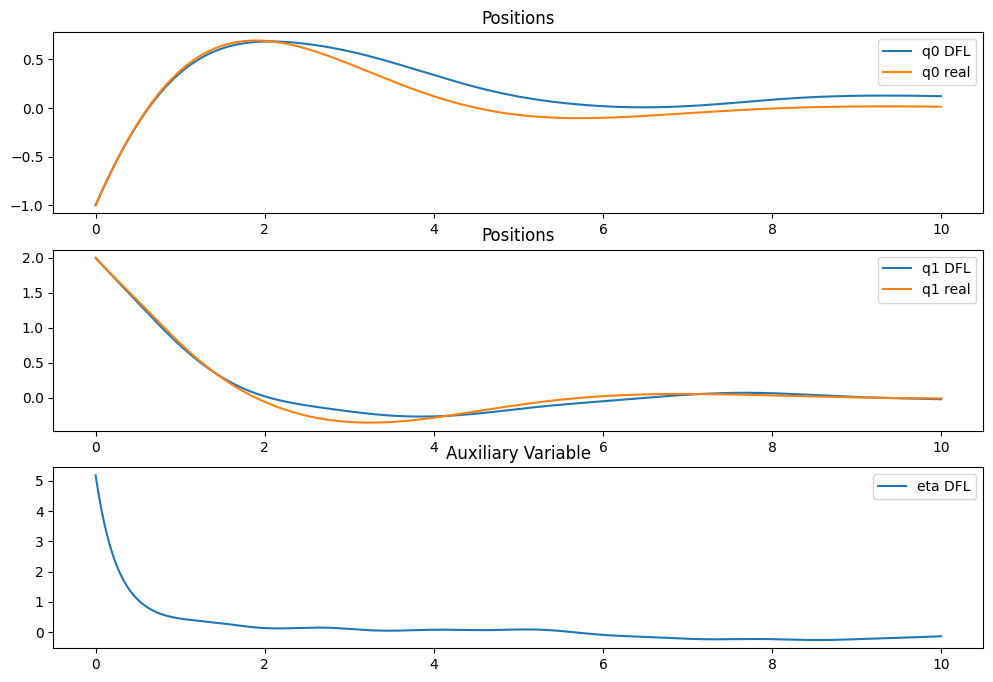

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
# sol.y = sol.y[:, :1000]
for i in range(2):
    ax[i].plot(ts[:len(lin_sol.y[i])], lin_sol.y[i], label=f"q{i} DFL")
    ax[i].set_title('Positions')
    ax[i].plot(ts[:len(sol.y[i])], sol.y[i], label=f"q{i} real")
    ax[i].legend()
eta_sol = np.array(
    [eta_fn(state_i) for state_i in sol.y.T]
).reshape(-1, 1)
ax[2].set_title('Auxiliary Variable')
ax[2].plot(ts[:len(lin_sol.y[-1])], lin_sol.y[-1], label=f"eta DFL")
# ax[2].plot(ts, eta_sol[0], label="eta real")
ax[2].legend()
plt.show()

## Regions of Attraction

### LTI LQR

Now, let's analyse the following Lyapunov candidate:
$$V = \frac{1}{2} \eta^T P \eta,$$
where $P$ is a matrix, resulting from LTI LQR discrete control.

In [19]:
# A = np.zeros(((nx+nv+neta, nx+nv+neta)))
# A[:nx+nv, :nx+nv] = A_x
# A[:nx+nv, nx+nv:nx+nv+neta_dfl] = A_eta
# A[nx+nv:] = H_w
A = H_w

In [20]:
from scipy.linalg import solve_continuous_lyapunov as lyap

Q = np.eye(nx+nv+neta)
P = lyap(A.T, -Q)

In [21]:
def is_pos_def(A):
    if np.allclose(A, A.T, rtol=1e-3):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            print('Symmetric, but not p.d.')
            return False
    else:
        print('Not symmetric')
        return False

is_pos_def(P)

Symmetric, but not p.d.


False

In [36]:
def sampling_roa(f, V, dV, x_bounds, N=100):
    x_min, x_max = x_bounds
    x_range = np.array(x_max) - np.array(x_min)
    n = np.shape(x_min)[0]

    c = np.inf
    ct = []

    for i in range(N):
        x_i = x_min + x_range*np.random.rand(n)
        dV_i = dV(x_i)
        V_i = V(x_i)
        if V_i < 0:
            continue
        if dV_i >= 0 and V_i <= c:
            c = V_i
            ct.append(c)  
    
    return c, np.array(ct)

In [37]:
jacobian = cs.Function('jacobian', [state], [cs.jacobian(f(state), state)])
A_taylor = jacobian(np.zeros(2))
Q_taylor = np.eye(2)

P_taylor = lyap(A_taylor.T, -Q_taylor)

V_taylor = 1/2 * state.T @ P_taylor @ state
V_taylor_fn = cs.Function('V_taylor', [state], [V_taylor])
V_taylor_dot_fn = cs.Function('V_taylor', [state], [cs.jacobian(V_taylor, state) @ f(state)])

In [38]:
state_lims = np.array([
    [-2, -2],
    [2, 2]
])

r_taylor, _ = sampling_roa(f, V_taylor_fn, V_taylor_dot_fn, state_lims, N = 10000)
levelset_taylor = cs.Function('V_level', [state], [V_taylor - r_taylor])
r_taylor

DM(1.93959)

Let's create the following optimization problem:
$$
\begin{aligned}
\min_{P_o} \quad & ||P - P_o|||_2^2\\
\textrm{s.t.} \quad & z(0)^TP_oz(0) \geq 0\\
  & z(x_i)^TP_oz(x_i) > 0 \quad i = 0,\ \ldots,\ N-1    \\
  & z(x_i)^T(P_o + P_o^T)\dot{z}(x_i) \leq 0 \quad i = 0,\ \ldots,\ N-1    \\
\end{aligned}
$$


In [39]:
x_min, x_max, dx = -3, 3.01, 5e-2
x_mesh = np.array(
    np.meshgrid(
        np.arange(x_min, x_max, dx),
        np.arange(x_min, x_max, dx),
    )
).reshape(nx+nv, -1).T
x_mesh = np.concatenate([x_mesh[:len(x_mesh)//2], x_mesh[len(x_mesh)//2+1:]], axis=0)

x_in_ellipse = []

for x_mesh_i in x_mesh:
    if levelset_taylor(x_mesh_i) < 0:
        x_in_ellipse.append(x_mesh_i)

x_mesh = np.array(x_in_ellipse)

eta_mesh = np.array(
    [eta_fn(x_mesh_i) for x_mesh_i in x_mesh]
)[:, :, 0]

state_mesh = np.concatenate([x_mesh, eta_mesh], axis=1)

state_mesh.shape

(4368, 23)

In [40]:
v_dot_mesh = np.array(
    [f_np(0, state_i) for state_i in x_mesh]
)

eta_dot_mesh = np.array(
    [eta_dot_fn(x_mesh_i, v_dot_i[-nv:]) for x_mesh_i, v_dot_i in zip(x_mesh, v_dot_mesh)]
)[:, :, 0]

state_dot_mesh = np.concatenate(
    [v_dot_mesh, eta_dot_mesh], axis=1
)

state_dot_mesh.shape

(4368, 23)

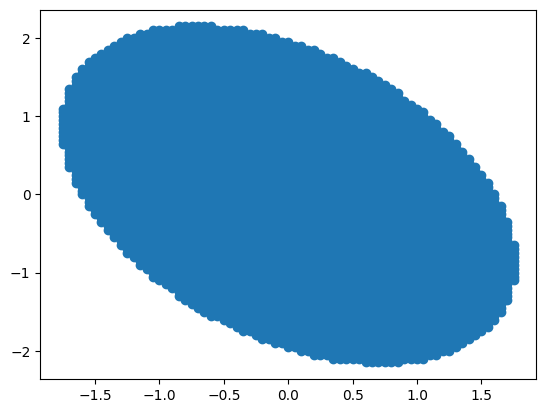

In [41]:
plt.scatter(*(x_mesh.T))

In [42]:
n_neg = 0
for i in range(len(state_mesh)):
    if state_mesh[i] @ P @ state_mesh[i] <= 0:
        n_neg += 1

print(f"Positive: {len(state_mesh)-n_neg}, negatives: {n_neg}")

Positive: 4073, negatives: 295


In [43]:
state0 = np.concatenate([np.zeros(nx+nv), np.array(eta_fn(np.zeros(nx+nv))).ravel()])

In [30]:
P_opt_cp = cp.Variable(P.shape)
objective_samples = 1/len(full_state_np) * cp.sum_squares(P - P_opt_cp)
constraints = [
    state_mesh_i.T @ P_opt_cp @ state_mesh_i >= 0
    for state_mesh_i in state_mesh
]
constraints += [
    state_mesh_i.T @ (P_opt_cp + P_opt_cp.T) @ state_dot_mesh_i <= 0
    for state_mesh_i, state_dot_mesh_i in zip(state_mesh, state_dot_mesh)
]
constraints.append(state0.T @ P_opt_cp @ state0 == 0)
problem_samples = cp.Problem(cp.Minimize(objective_samples), constraints)
result = problem_samples.solve(verbose=True, max_iter = 30000)

P_opt = P_opt_cp.value

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 11 02:17:24 PM: Your problem has 529 variables, 8737 constraints, and 0 parameters.
(CVXPY) Jan 11 02:17:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 11 02:17:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 11 02:17:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 11 02:17:25 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 11 02:17:25 PM: Compiling problem (target solver=OSQP).


In [31]:
n_neg = 0
for i in range(len(state_mesh)):
    if state_mesh[i] @ P_opt @ state_mesh[i] <= 0:
        n_neg += 1

print(f"Positive: {len(state_mesh)-n_neg}, negatives: {n_neg}")

Positive: 4368, negatives: 0


In [50]:
V = 1/2 * full_state.T @ P_opt @ full_state
V_fn = cs.Function('V', [state], [V])
V0 = V_fn(np.zeros(nx+nv))

V_dot_fn = cs.Function('V_dot', [state], [cs.jacobian(V, state) @ f(state)])

In [51]:
state_lims = np.array([
    [-3, -3],
    [3, 3]
])

r_dfl, _ = sampling_roa(f, V_fn, V_dot_fn, state_lims, N = 10000)
levelset_dfl = cs.Function('V_level', [state], [V - r_dfl])
r_dfl

DM(0.0125762)

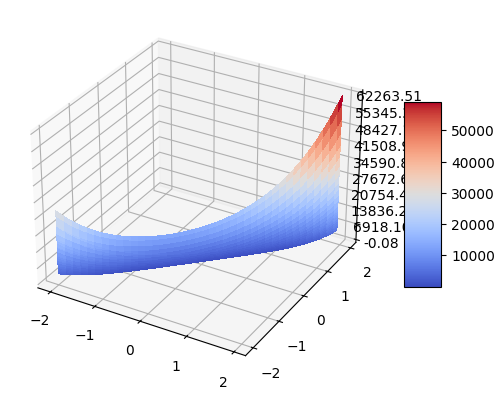

In [46]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-2, 2, dx)
Y = np.arange(-2, 2, dx)
x_mesh = np.meshgrid(
    X,
    Y,
)

levelset_mesh = np.array([
    [
        levelset_dfl([x_mesh[0][i, k], x_mesh[1][i, k]])
        for k in range(x_mesh[0].shape[1])
    ]   for i in range(x_mesh[0].shape[0])
])[:, :, 0, 0]

# Plot the surface.
surf = ax.plot_surface(X, Y, levelset_mesh, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

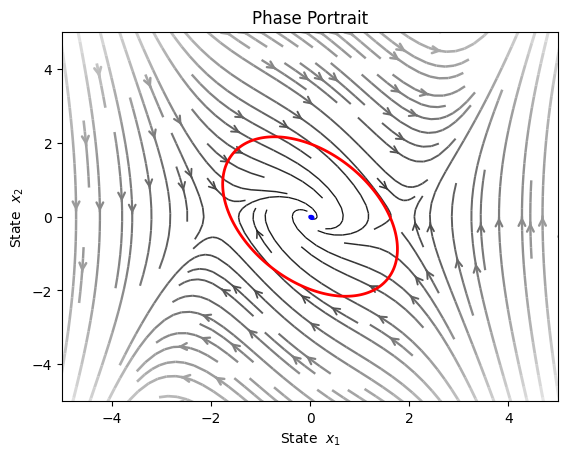

In [47]:
fig, ax = plt.subplots()
phase_portrait(f, ax=ax, x_range=[5, 5], density=1.2)
draw_elipse(
    [-5, 5], 
    ax=ax, 
    f = levelset_taylor, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'red',
    } 
)

draw_elipse(
    [-5, 5],
    ax=ax,  
    f = levelset_dfl, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'blue',
    } 
)

plt.show()